<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/end_point_motion_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Get end-point motion metrics per cell

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Import libraries

In [3]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import os
import os.path
from numpy import linalg as LA
import pickle
from os import listdir
from os.path import isfile, join
import re
import csv
from copy import deepcopy, copy
import glob
from scipy import stats
import ntpath
from skimage.io import imread, imsave, imshow
from scipy.stats import pearsonr
from scipy.stats import sem
from random import choices

#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries /content
from libraries.track_functions import *


In [4]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

import itertools
import math

import mediapy as media
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#!pip install heteromotility

In [6]:
def pearsonr_df(df):
  df_clean = df.dropna()
  return pearsonr(df_clean.iloc[:,0], df_clean.iloc[:,1])

###Input (read treatment data) and set output destination

In [7]:
#set destination path
output_path= 'gs://cellmbucket/analysis'

In [8]:
treatment_paths = ['cellmbucket/analysis/controls_old_new_paths.txt','cellmbucket/analysis/controls_paths.txt','cellmbucket/analysis/arpc2_control_paths.txt','cellmbucket/analysis/fascin_control_paths.txt']
#treatment_paths = ['cellmbucket/analysis/controls_old_new_paths.txt']
#treatment_paths = ['cellmbucket/analysis/controls_paths.txt','cellmbucket/analysis/arpc2_control_paths.txt','cellmbucket/analysis/fascin_control_paths.txt']

treatment = 'all'

if os.path.isdir(treatment):
  !rm -r {treatment}

!mkdir {treatment}

In [9]:
#read treatment locations file
file_paths =[]

for treatment_path in treatment_paths:

  !gsutil cp gs://{treatment_path} ./
  treatment_file = ntpath.basename(treatment_path)
  treatment_obj = open(treatment_file, "r")
  treatment_locs = treatment_obj.readlines()
  for i in range(1,len(treatment_locs)):
    if len(treatment_locs[i].strip("\n")) > 0: #if line contains data
      #file_paths.append(treatment_locs[i].strip("\n")+'_tracks_shape.pkl')
      file_paths.append(treatment_locs[i].strip("\n"))   


Copying gs://cellmbucket/analysis/controls_old_new_paths.txt...
/ [1 files][  311.0 B/  311.0 B]                                                
Operation completed over 1 objects/311.0 B.                                      
Copying gs://cellmbucket/analysis/controls_paths.txt...
/ [1 files][  345.0 B/  345.0 B]                                                
Operation completed over 1 objects/345.0 B.                                      
Copying gs://cellmbucket/analysis/arpc2_control_paths.txt...
/ [1 files][  290.0 B/  290.0 B]                                                
Operation completed over 1 objects/290.0 B.                                      
Copying gs://cellmbucket/analysis/fascin_control_paths.txt...
/ [1 files][  224.0 B/  224.0 B]                                                
Operation completed over 1 objects/224.0 B.                                      


In [10]:
file_paths

['cellmbucket/analysis_eliz_09162021/09162021',
 'cellmbucket/analysis_eliz_062719/controls_2019_062719_sample1',
 'cellmbucket/analysis_eliz_062719/controls_2019_062719_sample2',
 'cellmbucket/analysis_sam_062819/controls_2019_062819_sample1',
 'cellmbucket/analysis_sam_062819/controls_2019_062819_sample2',
 'cellmbucket/analysis_042221/06032020-JR20-control',
 'cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5',
 'cellmbucket/analysis_pri_050521/03122021-JR20P14-control',
 'cellmbucket/analysis_sam_042821/031521_control_sample3',
 'cellmbucket/analysis_sam_042821/031521_control_sample4',
 'cellmbucket/analysis_sam_042821/031521_control_sample5',
 'cellmbucket/analysis_eliz_05042021/trial1/05042021_ARPC2_KO_sample6',
 'cellmbucket/analysis_eliz_05042021/trial3/05112021_ARPC2_KO_sample3',
 'cellmbucket/analysis_eliz_05042021/trial4/05202021_ARPC2_KO_sample4',
 'cellmbucket/analysis_eliz_05042021/trial5/060622021_ARPC2_KO_sample3',
 'cellmbucket/analysis_eliz_05262021/tri

In [11]:
#Parameters to compute motion metrics
center='approximate-medoid'
pixel_size=2*0.645 #um. factor of 2 because image was rescaled
sampling_t=1 #sampling time (10min)

In [12]:
#READ TRACKS
for file in file_paths:
  #GET TRACKS
  !gsutil cp gs://{file}_tracks_shape.pkl ./{treatment}
  

Copying gs://cellmbucket/analysis_eliz_09162021/09162021_tracks_shape.pkl...
/ [1 files][514.6 KiB/514.6 KiB]                                                
Operation completed over 1 objects/514.6 KiB.                                    
Copying gs://cellmbucket/analysis_eliz_062719/controls_2019_062719_sample1_tracks_shape.pkl...
/ [1 files][737.3 KiB/737.3 KiB]                                                
Operation completed over 1 objects/737.3 KiB.                                    
Copying gs://cellmbucket/analysis_eliz_062719/controls_2019_062719_sample2_tracks_shape.pkl...
/ [1 files][846.6 KiB/846.6 KiB]                                                
Operation completed over 1 objects/846.6 KiB.                                    
Copying gs://cellmbucket/analysis_sam_062819/controls_2019_062819_sample1_tracks_shape.pkl...
/ [1 files][795.8 KiB/795.8 KiB]                                                
Operation completed over 1 objects/795.8 KiB.                        

In [13]:
#READ MASKS
#for file in file_paths:

  #!gsutil cp gs://{file}_tracks_masks.zip ./{treatment}
  #!unzip ./{treatment}/{ntpath.basename(file+'_tracks_masks.zip')} -d ./controls

###Compile tracks and get end-point metrics

In [14]:
#COMPILE TREATMENT TRACKS
tracks =[]
tracks_geo =[]

for file in file_paths:
  tracksp,tracksgeop = read_tracks_aut([treatment+'/'+ ntpath.basename(file)+'_tracks_shape.pkl'] ,pixel_size,center)
  #!rm ./{treatment+'/'+ntpath.basename(file)}
  if len(tracksp)==0: print("number of tracks read is 0")
  #tracksp=smooth_tracks(tracksp,3)

  #remove tracks with less than 11 points
  tracksp = [track for track in tracksp if len(track) > 10 ]
  tracksgeop = [track for track in tracksgeop if len(track) > 10 ]

  tracks += tracksp
  tracks_geo += tracksgeop
 

In [15]:
#GET CELL-AVERAGED METRICS, get gel-region, experiment
gelregion=[]
experiment=[]
trackid=[]
absskew=[]
mean_retr_norm_radii=[]

for i in range(len(tracks_geo)):
  gelregion.append( tracks_geo[i]["gel-region"].iloc[0])
  experiment.append(tracks_geo[i]["experiment"].iloc[0])
  trackid.append(tracks_geo[i]["track_id"].iloc[0])
  absskew.append(tracks_geo[i]["abs-skew"].mean())
  mean_retr_norm_radii.append(tracks_geo[i]["mean_retr_norm_radii"].mean())

In [16]:
#GET TRACKS MOTION METRICS AND ADD GEL-REGION AND EXPERIMENT
stepsizes,turns,meancoskturn,stderrcoskturn, tseries_stats, endpointcells = basic_stats(tracks,pixel_size,sampling_t)
endpointcells['gel-region']=gelregion
endpointcells['experiment']=experiment
endpointcells['track_id']=trackid
endpointcells['abs-skew']=absskew
endpointcells['mean_retr_norm_radii']=mean_retr_norm_radii


/content/libraries/track_functions.py:205: RuntimeWarning: invalid value encountered in true_divide
  meanpathlength=sum_pathlengths/nlengths
/content/libraries/track_functions.py:206: RuntimeWarning: invalid value encountered in true_divide
  stddevpathlength = np.sqrt(sum_squared_pathlengths/nlengths - meanpathlength**2 )
/content/libraries/track_functions.py:208: RuntimeWarning: invalid value encountered in true_divide
  meanfmi=sum_fmis/nlengths
/content/libraries/track_functions.py:209: RuntimeWarning: invalid value encountered in true_divide
  stddevfmi = np.sqrt(sum_squared_fmis/nlengths - meanfmi**2 )
/content/libraries/track_functions.py:211: RuntimeWarning: invalid value encountered in true_divide
  meanpmi=sum_pmis/nlengths
/content/libraries/track_functions.py:212: RuntimeWarning: invalid value encountered in true_divide
  stddevpmi = np.sqrt(sum_squared_pmis/nlengths - meanpmi**2 )
/content/libraries/track_functions.py:214: RuntimeWarning: invalid value encountered in true

In [17]:
#endpointcells

In [18]:
track_ind_high = np.where((endpointcells["T"] >= 200) & (endpointcells["gel-region"] == "gradient2")  )[0]
pearsonr(endpointcells['abs-skew'].iloc[track_ind_high],endpointcells['FMI'].iloc[track_ind_high])

(0.3161254802600695, 0.006072086637835959)

(array([ 15.,  19.,  44.,  75., 185., 159.,  70.,  41.,  12.,  12.]),
 array([-0.86292093, -0.68051431, -0.49810769, -0.31570108, -0.13329446,
         0.04911215,  0.23151877,  0.41392538,  0.596332  ,  0.77873861,
         0.96114523]),
 <a list of 10 Patch objects>)

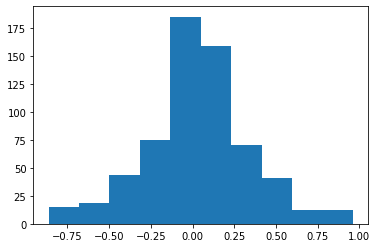

In [21]:
plt.hist(endpointcells["FMI"])

(array([186., 225., 136.,  49.,  24.,   6.,   3.,   2.,   0.,   1.]),
 array([0.04254058, 0.21931112, 0.39608167, 0.57285221, 0.74962275,
        0.9263933 , 1.10316384, 1.27993439, 1.45670493, 1.63347547,
        1.81024602]),
 <a list of 10 Patch objects>)

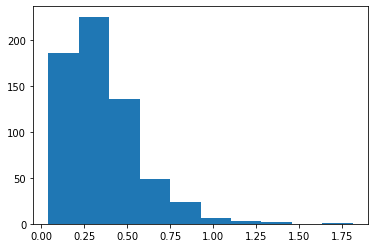

In [22]:
plt.hist(endpointcells["abs-skew"])